In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torchvision.transforms import v2
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from torchinfo import summary
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
import shutil

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(root_dir))
        self.class_labels = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.images = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for image_file in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_file)
                    self.images.append(image_path)
                    self.labels.append(self.class_labels[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('L')  # Ensure images are loaded in gray mode
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transformers = transforms.ToTensor()

aug_train_dataset = CustomDataset(root_dir='/kaggle/input/emotion-detection-caers/Caer_resized/caers_resized_train', transform=transformers)
aug_val_dataset = CustomDataset(root_dir='/kaggle/input/emotion-detection-caers/Caer_resized/caers_resized_val', transform=transformers)
aug_test_dataset = CustomDataset(root_dir='/kaggle/input/emotion-detection-caers/Caer_resized/caers_resized_test', transform=transformers)

In [4]:
train_batch = 300
val_batch = 300
train_loader = DataLoader(aug_train_dataset, batch_size=train_batch, shuffle=True)
val_loader = DataLoader(aug_val_dataset, batch_size=val_batch, shuffle= False)

In [5]:
test_batch = 300
test_loader = DataLoader(aug_test_dataset, batch_size=test_batch, shuffle= False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU = ", torch.cuda.is_available())

GPU =  True


In [7]:
# nn model
class ConvoNetwork(nn.Module):
  def __init__(self , l1 = 80, l2 = 32):
    super().__init__()
    #convo layers
    self.bn0 = nn.BatchNorm2d(1)
    
    self.conv1 = nn.Conv2d(1 ,32, (5,5) , 1 , padding = 'same')
    self.bn1 = nn.BatchNorm2d(32)
    self.max0 = nn.AvgPool2d(3 , stride = 2)
    
    self.conv2 = nn.Conv2d(32, 64 , (3,3) , 2 , padding = 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.max1 = nn.MaxPool2d(2)
    
    self.conv3= nn.Conv2d(64,64 ,(3,3),1,padding = 'same' )
    self.bn3 = nn.BatchNorm2d(64)
    
    self.conv4 = nn.Conv2d(64,128 , (3,3),2,padding = 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.drop = nn.Dropout(0.6)
    self.conv5 = nn.Conv2d(128,128 , (3,3),1)
    
    self.fc1 = nn.Linear(128,l1)
    self.fc2 = nn.Linear(l1,l2)
    self.out = nn.Linear(l2,7)

  def forward(self, X):
    X = self.bn0(X)
    
    X = self.conv1(X)
    X = self.bn1(X)
    X = F.relu(X)
    X = self.max0(X)
    
    X = self.conv2(X)
    X = self.bn2(X)
    X = F.relu(X)
    X = self.max1(X)
    
    X = self.conv3(X)
    X = self.bn3(X)
    X = F.relu(X)
    X = self.max1(X)
    
    X = self.conv4(X)
    X = self.bn4(X)
    X = F.relu(X)
    X = self.max0(X)
    
    X = self.conv5(X)
    X = F.relu(X)
    X = self.drop(X)
    #Flatten
    X = torch.flatten(X,1)
    
    #Dense
    X = self.fc1(X)
    X = F.relu(X)
    
    X = self.fc2(X)
    X = F.relu(X)
    
    X = self.out(X)
    return X


In [8]:
model = ConvoNetwork()
#model= nn.DataParallel(model)


model.to(device = device)

ConvoNetwork(
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max0): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.6, inplace=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(

In [9]:
summary(model, input_size=(train_batch, 1, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
ConvoNetwork                             [300, 7]                  --
├─BatchNorm2d: 1-1                       [300, 1, 227, 227]        2
├─Conv2d: 1-2                            [300, 32, 227, 227]       832
├─BatchNorm2d: 1-3                       [300, 32, 227, 227]       64
├─AvgPool2d: 1-4                         [300, 32, 113, 113]       --
├─Conv2d: 1-5                            [300, 64, 57, 57]         18,496
├─BatchNorm2d: 1-6                       [300, 64, 57, 57]         128
├─MaxPool2d: 1-7                         [300, 64, 28, 28]         --
├─Conv2d: 1-8                            [300, 64, 28, 28]         36,928
├─BatchNorm2d: 1-9                       [300, 64, 28, 28]         128
├─MaxPool2d: 1-10                        [300, 64, 14, 14]         --
├─Conv2d: 1-11                           [300, 128, 7, 7]          73,856
├─BatchNorm2d: 1-12                      [300, 128, 7, 7]          256


In [10]:
# Cost funcn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001,weight_decay = 0.0001)

In [11]:
epochs = 100
best_acc = 0
patience = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in range(epochs):
    losses = 0
    train_count = 0
    epoch_train_correct = 0
    epoch_train_size = 0

    # Training loop
    model.train()

    for b, (X_train, y_train) in enumerate(train_loader):
        if b % 10 == 0:
          print('/',end = "")

        X_train = X_train.to(device = device)
        y_train = y_train.to(device = device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()# gradients are add in prev value so, prev grad = 0 
        loss.backward()# actual back prop for grad calc
        optimizer.step()# updating parameters based on calculated grads
        
        losses += loss.item()
        train_count += 1
        
        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum().item()
        epoch_train_correct += batch_corr
        epoch_train_size += len(X_train)


    mean_loss = losses/train_count
    train_losses.append(mean_loss)
    
    train_acc = epoch_train_correct/ epoch_train_size
    train_accuracies.append(train_acc)
    print("")
    print(f"Epoch {i+1} : training accuracy = {train_acc} training loss = {mean_loss}",end="")
    
    # Testing loop
    val_losses_batchwise = 0
    val_epoch_size = 0
    val_count = 0
    val_correct_epoch = 0
    with torch.no_grad():
        model.eval()
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test = X_test.to(device = device)
            y_test = y_test.to(device = device)

            y_val = model(X_test)
            lpss = criterion(y_val, y_test)
            val_losses_batchwise += lpss.item()

            predicted = torch.max(y_val, 1)[1]
            test_corr = (predicted == y_test).sum().item()
            val_correct_epoch += test_corr
            val_epoch_size += len(y_val)
            val_count += 1


    mean_val_loss = val_losses_batchwise/val_count
    val_losses.append(mean_val_loss)
    
    validation_accuracy = val_correct_epoch/val_epoch_size
    val_accuracies.append(validation_accuracy)
    print(f" , validation accuracy = {validation_accuracy} validation loss = {mean_val_loss}")
    

    if validation_accuracy > best_acc:
        best_acc = validation_accuracy
        count = 0
        checkpoint = {
        'epoch': i + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': best_acc,
        }
        torch.save(checkpoint,'/kaggle/working/tinyTrying70.pth.tar')
    else:
        count += 1
    if count == patience:
        print("Early Stopping !!!")
        break


////////////
Epoch 1 : training accuracy = 0.18222590413072046 training loss = 1.9214027732865424 , validation accuracy = 0.16228571428571428 validation loss = 1.9521610339482625
////////////
Epoch 2 : training accuracy = 0.22227618122607554 training loss = 1.870261411381583 , validation accuracy = 0.18057142857142858 validation loss = 1.9759740978479385
////////////
Epoch 3 : training accuracy = 0.2575844141004399 training loss = 1.8115496859591231 , validation accuracy = 0.18571428571428572 validation loss = 2.100430508454641
////////////
Epoch 4 : training accuracy = 0.2943209735473919 training loss = 1.7428694983832858 , validation accuracy = 0.17042857142857143 validation loss = 2.467292735973994
////////////
Epoch 5 : training accuracy = 0.3338856196080672 training loss = 1.6636177230085063 , validation accuracy = 0.21185714285714285 validation loss = 2.277701253692309
////////////
Epoch 6 : training accuracy = 0.3639376106953094 training loss = 1.583600762562874 , validation acc

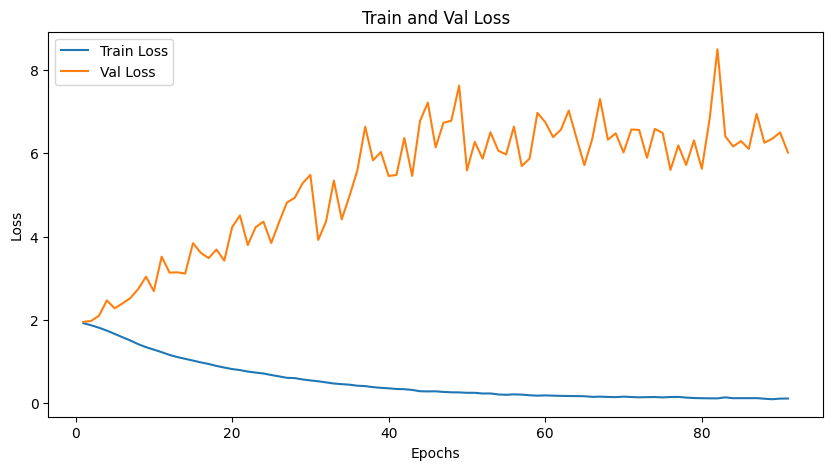

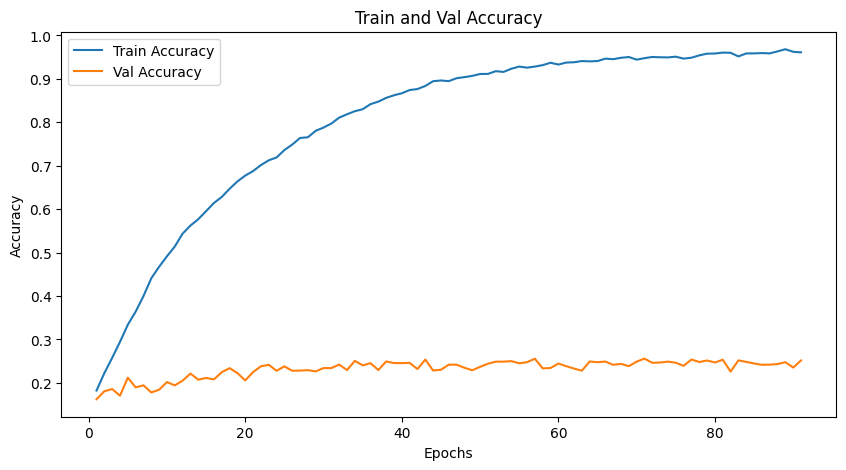

In [12]:
e = range(1, len(val_losses) + 1)

# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(e, train_losses, label='Train Loss')
plt.plot(e, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()
plt.show()

# Plot train and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(e, train_accuracies, label='Train Accuracy')
plt.plot(e, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Val Accuracy')
plt.legend()
plt.show()

In [13]:
loaded_model = ConvoNetwork()
#loaded_model = nn.DataParallel(loaded_model)

check = torch.load('/kaggle/working/tinyTrying70.pth.tar', map_location=torch.device(device))
loaded_model.load_state_dict(check['model_state_dict'])
loaded_model.to(device = device)

ConvoNetwork(
  (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max0): AvgPool2d(kernel_size=3, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.6, inplace=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
check['epoch']

71

In [16]:
Y_PRED = []
Y_TEST = []
with torch.no_grad():
    loaded_model.eval()
    for b, (X_test, y_test) in enumerate(test_loader):
             X_test = X_test.to(device = device)
             y_test = y_test.to(device = device)
                
             y_val = loaded_model(X_test)
             ypred = torch.max(y_val, 1)[1]
                
             Y_PRED.extend(ypred.tolist())
             Y_TEST.extend(y_test.tolist())
         
print(len(Y_PRED) , len(Y_TEST))

20992 20992


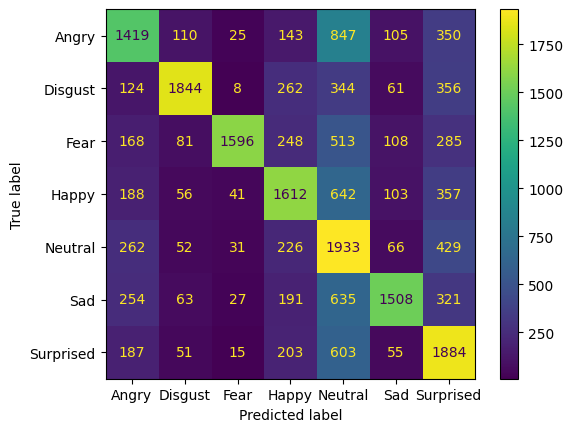

In [17]:
confusion = confusion_matrix(Y_TEST, Y_PRED)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprised"])

cm_display.plot()
plt.show()

In [18]:
accuracy = sum(pred == true for pred, true in zip(Y_PRED, Y_TEST)) / len(Y_TEST)
print(accuracy)

0.5619283536585366
